In [1]:
from pathlib import Path

import pandas as pd
from loguru import logger
from sklearn.model_selection import train_test_split


### Data Section

In [2]:
class DataLoader:
    def __init__(
            self, data_path, rrs_file='df_nwa_rrs.pqt',
            phy_file='df_nwa_phyto.pqt'):
        data_path = Path(data_path).resolve()
        preprocessed_data_path = data_path #/ '02_extracted/pcc_sims/subset'
        self.data_path = preprocessed_data_path
        self.X_name = rrs_file
        self.Y_name = phy_file
        logger.debug(f"Data directory set to {self.data_path.as_posix()}")
        logger.debug(f'Rrs file used: {self.X_name}')
        logger.debug(f'Phytoplankton file use {self.Y_name}')
   
    def load_data(self):
        """Loads and preprocesses data."""
        try:
            dX = pd.read_parquet(self.data_path / self.X_name, engine='pyarrow')
            dY = pd.read_parquet(self.data_path / self.Y_name, engine='pyarrow')

            # Data preprocessing (handle missing values, type conversion, etc.)
            dX = dX.astype(float) 
            dY = dY.astype(float) 

            return dX, dY

        except FileNotFoundError:
            logger.error(f"Error: Files not found in directory {self.data_path}")
            return None, None  # Return None on error
        except pd.errors.EmptyDataError:
            logger.error(f"Error: Empty data files in directory {self.data_path}")
            return None, None
        except Exception as e:  # Catch other potential exceptions
            logger.error(f"Error loading data: {e}")
            return None, None 
        

In [3]:
data_path = Path('../../data/02_extracted/pcc_sims/subset')

In [130]:
Path.cwd()

PosixPath('/Users/erdemkarakoylu/projex/toa_2_phyto_ml/multioutput_regression/notebooks')

In [128]:
data_path.absolute()

PosixPath('/Users/erdemkarakoylu/projex/toa_2_phyto_ml/multioutput_regression/notebooks/../../data/02_extracted/pcc_sims/subset')

In [4]:
loader = DataLoader(data_path=data_path)

2024-07-28 15:37:02.955 | DEBUG    | __main__:__init__:10 - Data directory set to /Users/erdemkarakoylu/projex/toa_2_phyto_ml/data/02_extracted/pcc_sims/subset
2024-07-28 15:37:02.957 | DEBUG    | __main__:__init__:11 - Rrs file used: df_nwa_rrs.pqt
2024-07-28 15:37:02.957 | DEBUG    | __main__:__init__:12 - Phytoplankton file use df_nwa_phyto.pqt


In [5]:
dX, dY =  loader.load_data()

In [6]:
dX.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7812 entries, 0 to 11156
Columns: 501 entries, 250 to 750
dtypes: float64(501)
memory usage: 29.9 MB


In [7]:
dY.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7812 entries, 0 to 11156
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dia        7812 non-null   float64
 1   chl        7812 non-null   float64
 2   cya        7812 non-null   float64
 3   coc        7812 non-null   float64
 4   din        7812 non-null   float64
 5   pha        7812 non-null   float64
 6   tot_cphyl  7812 non-null   float64
dtypes: float64(7)
memory usage: 488.2 KB


In [8]:
dX_train, dX_test, dY_train, dY_test = train_test_split(
    dX, dY
)

In [9]:
dX_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5859 entries, 8340 to 8141
Columns: 501 entries, 250 to 750
dtypes: float64(501)
memory usage: 22.4 MB


In [10]:
dX_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1953 entries, 7942 to 6109
Columns: 501 entries, 250 to 750
dtypes: float64(501)
memory usage: 7.5 MB


### Modeling Section

In [11]:
import mlflow
import mlflow.xgboost
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import numpy as np
from sklearn.utils import resample

In [61]:
class XGBoostTrainer:
    def __init__(self, params):
        self.params = params

    def train_model(self, X_train, y_train):
        """Trains the XGBoost model."""
        with mlflow.start_run():
            model = MultiOutputRegressor(xgb.XGBRegressor(**self.params))
            model.fit(X_train, y_train)
            return model
        
    def predict_with_uncertainty(
            self, model, X_new, num_bootstrap_samples=100, return_all_predictions=False):
        """
        Predicts target values with uncertainty estimation using bootstrapping.
        """

        all_predictions = np.zeros(
            (
                num_bootstrap_samples, X_new.shape[0], 
                len(self.params["objective"])
                )
            )
        for i in range(num_bootstrap_samples):
            X_resampled, y_resampled = resample(self.X_train, self.y_train)
            model.fit(X_resampled, y_resampled)
            all_predictions[i] = model.predict(X_new)
        
        if return_all_predictions:
            return all_predictions
        # Calculate statistics across bootstrap samples
        mean_predictions = np.mean(all_predictions, axis=0)
        std_dev_predictions = np.std(all_predictions, axis=0)
        return mean_predictions, std_dev_predictions


In [13]:
params = {
    "objective": "reg:squarederror",  # Basic parameter
    "n_estimators": 50,                # Small number for faster testing
    "seed": 42                        # For reproducibility
    }
trainer = XGBoostTrainer(params=params)
xgbmodel = trainer.train_model(dX_train, dY_train)

In [14]:
xgbmodel

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

### Model Evaluation

In [15]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    mean_absolute_percentage_error)

In [16]:
dY_pred = xgbmodel.predict(dX_test)

In [18]:
dY_pred = pd.DataFrame(
    dY_pred, columns=dY_test.columns
    )

In [19]:
dY_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1953 entries, 7942 to 6109
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dia        1953 non-null   float64
 1   chl        1953 non-null   float64
 2   cya        1953 non-null   float64
 3   coc        1953 non-null   float64
 4   din        1953 non-null   float64
 5   pha        1953 non-null   float64
 6   tot_cphyl  1953 non-null   float64
dtypes: float64(7)
memory usage: 122.1 KB


In [20]:
dY_test.describe()

,dia,chl,cya,coc,din,pha,tot_cphyl
count,1953.000000,1953.000000,1.953000e+03,1.953000e+03,1.953000e+03,1.953000e+03,1953.000000
mean,0.141851,0.096182,3.550296e-02,9.737827e-03,1.482432e-02,4.465218e-20,0.298098
std,0.158708,0.074645,3.945206e-02,1.713661e-02,3.053698e-02,5.895226e-19,0.130498
min,0.001063,0.000003,8.594044e-10,7.847401e-07,2.621774e-21,3.078855e-34,0.114001
25%,0.020940,0.031531,8.650867e-04,6.641655e-05,2.253495e-07,5.876867e-33,0.196260
50%,0.040449,0.091827,1.749164e-02,5.372957e-04,6.248682e-05,5.247178e-30,0.253330
75%,0.280020,0.140310,6.717239e-02,1.214327e-02,1.174277e-02,4.182139e-26,0.381332
max,0.816943,0.395993,1.620772e-01,9.793374e-02,2.324301e-01,1.598939e-17,1.129773


In [45]:
dY_test.to_csv('~/Desktop/dy_test.csv')

In [107]:
def model_eval (dY_true, dY_pred):
    scores_dict = dict()
    for col in dY_true.columns:  # Iterate over each output column
        mse = mean_squared_error(
            dY_true[col], dY_pred[col])  
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(
            dY_true[col], dY_pred[col])
        r2 = r2_score(
            dY_true[col], dY_pred[col])
        mape = mean_absolute_percentage_error(
           dY_true[col], dY_pred[col] 
        )
        mae_to_dev_ratio = mae / dY_true[col].std()
        logger.info(f"\nMetrics for {col}:")
        logger.info(f"  MSE: {mse:.4f}")
        logger.info(f"  RMSE: {rmse:.4f}")
        logger.info(f"  MAE: {mae:.4f}")
        logger.info(f"  R-squared: {r2:.4f}")
        logger.info(f"  MAE/StDev_true {mae_to_dev_ratio:.3f}")
        scores_dict[col] = dict(mse=mse, rmse=rmse, mae=mae, r2=r2, mape=mape, mae_2_true_std_ratio=mae_to_dev_ratio)
    return scores_dict

In [28]:
model_eval(dY_test, dY_pred)

2024-07-28 15:46:04.336 | INFO     | __main__:model_eval:14 - 
Metrics for dia:
2024-07-28 15:46:04.337 | INFO     | __main__:model_eval:15 -   MSE: 0.0018
2024-07-28 15:46:04.337 | INFO     | __main__:model_eval:16 -   RMSE: 0.0423
2024-07-28 15:46:04.337 | INFO     | __main__:model_eval:17 -   MAE: 0.0236
2024-07-28 15:46:04.338 | INFO     | __main__:model_eval:18 -   R-squared: 0.9290
2024-07-28 15:46:04.338 | INFO     | __main__:model_eval:19 -   MAE/StDev_true 0.149
2024-07-28 15:46:04.340 | INFO     | __main__:model_eval:14 - 
Metrics for chl:
2024-07-28 15:46:04.341 | INFO     | __main__:model_eval:15 -   MSE: 0.0009
2024-07-28 15:46:04.341 | INFO     | __main__:model_eval:16 -   RMSE: 0.0302
2024-07-28 15:46:04.342 | INFO     | __main__:model_eval:17 -   MAE: 0.0211
2024-07-28 15:46:04.343 | INFO     | __main__:model_eval:18 -   R-squared: 0.8361
2024-07-28 15:46:04.344 | INFO     | __main__:model_eval:19 -   MAE/StDev_true 0.283
2024-07-28 15:46:04.346 | INFO     | __main__:mo

Good results for 
* Tot CHL
* Dia
* Cya

### Understanding the results

In [31]:
import matplotlib.pyplot as pp
import seaborn as sb

In [118]:
def plot_residuals(y_true, y_pred, ax, data_name):
    """Plots residuals for model-predicted targets."""
    errors = y_pred - y_true
    ss = ax.get_subplotspec()
    ax.scatter(y_pred, errors)
    if ss.is_first_row():
        ax.set_xlabel('Predicted values')
    else:
        ax.set_ylabel('')
    if ss.is_first_col():
        ax.set_ylabel('Residuals')
    else:
        ax.set_ylabel("")
    ax.set_title(f"Residual Plot for {data_name}")
    ax.axhline(y=0, color='r', linestyle='--')

In [42]:
dY_pred.shape

(1953, 7)

In [49]:
er = dY_test[col].values - dY_pred[col].values

In [50]:
er.shape

(1953,)

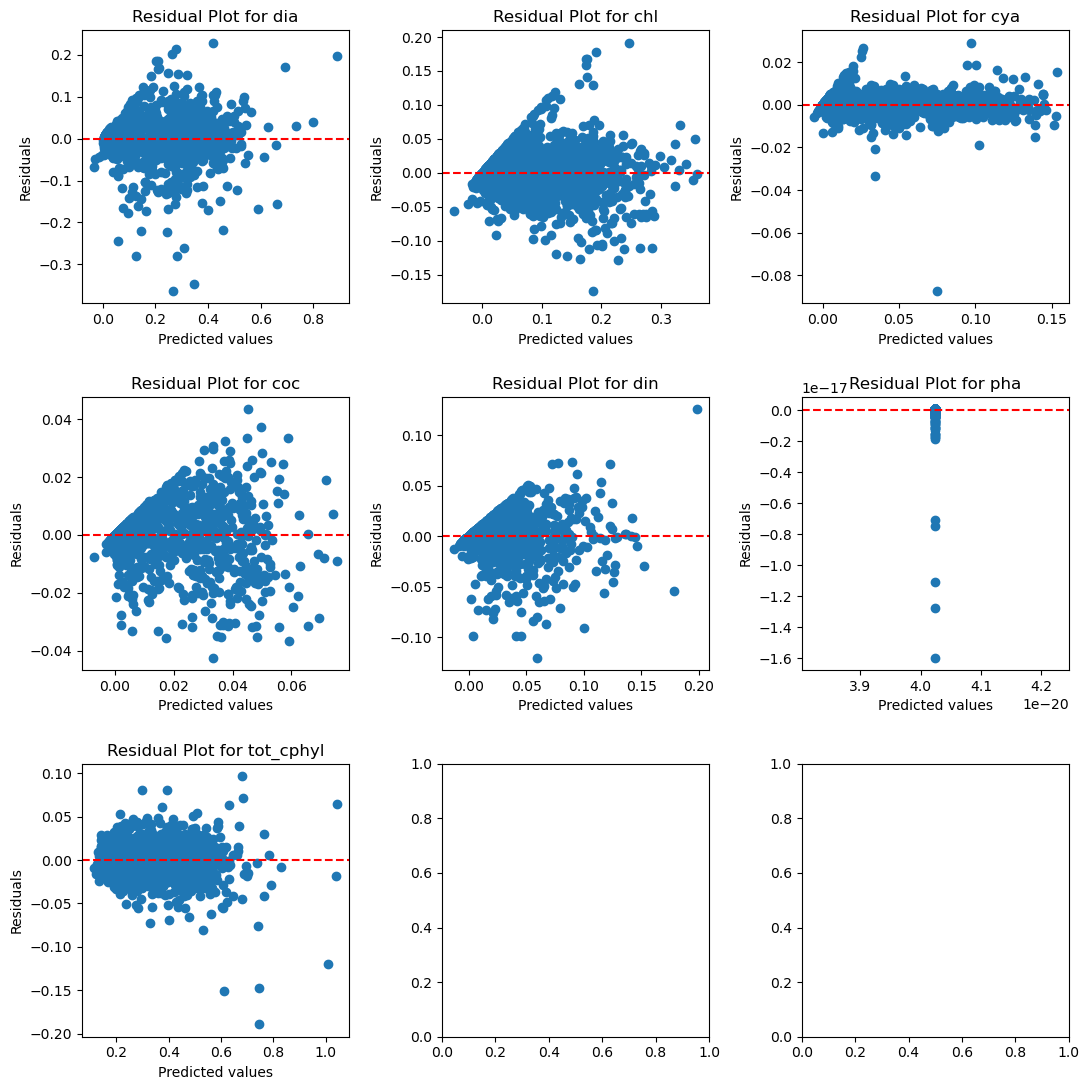

In [54]:
f, axs = pp.subplots(nrows=3, ncols=3, figsize=(11, 11))
for ax, col in zip(axs.ravel(), dY_test.columns):
    try:
        plot_residuals(dY_test[col].values, dY_pred[col].values, ax, col)
    except:
        logger.error(f"problem with {col}")
f.tight_layout()   


---
### Next is to retrain and predict with standardized target values.

<u>Why?</u>

Consistent Learning:
<br>$\rightarrow$ When multiple targets have drastically different scales, the model might implicitly focus more on learning patterns in the targets with larger magnitudes. <br>$\rightarrow$ Standardization can help bring all targets to a similar scale, potentially improving learning across all outputs.

In [55]:
from sklearn.preprocessing import StandardScaler

In [ ]:
x_scaler = StandardScaler()
X_train_s = x_scaler.fit_transform(dX_train)

In [58]:
y_scaler = StandardScaler()
Y_train_s = y_scaler.fit_transform(dY_train)

In [60]:
dY_train_s = pd.DataFrame(data=Y_train_s, columns=dY_train.columns)
dY_train_s.describe()

,dia,chl,cya,coc,din,pha,tot_cphyl
count,5.859000e+03,5.859000e+03,5.859000e+03,5.859000e+03,5.859000e+03,5859.000000,5.859000e+03
mean,3.274390e-17,-8.489161e-18,-1.588686e-16,-6.670055e-17,3.031843e-17,0.000000,7.276423e-17
std,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085,1.000085e+00
min,-8.679704e-01,-1.272533e+00,-8.994055e-01,-5.634817e-01,-4.799896e-01,-0.067921,-1.402527e+00
25%,-7.513667e-01,-8.707179e-01,-8.738422e-01,-5.595520e-01,-4.799832e-01,-0.067921,-7.605780e-01
50%,-6.363160e-01,-8.572448e-02,-4.580600e-01,-5.320264e-01,-4.785682e-01,-0.067921,-3.573043e-01
75%,8.729240e-01,6.005606e-01,7.853097e-01,8.804718e-02,-9.272327e-02,-0.067921,6.093456e-01
max,1.017176e+01,5.037224e+00,3.713846e+00,5.253937e+00,7.804201e+00,31.372671,1.201592e+01


In [62]:
trainer = XGBoostTrainer(params=params)
xgbmodel_s = trainer.train_model(dX_train, dY_train_s)

In [63]:
dY_test_s = y_scaler.transform(dY_test)

In [67]:
Y_pred_s = xgbmodel_s.predict(dX_test)

In [68]:
Y_pred = y_scaler.inverse_transform(Y_pred_s)

In [108]:
dY_pred_rs = pd.DataFrame(Y_pred, columns=dY_test.columns)

Next is to compute metrics for this, then to experiment with xscaled

In [109]:
eval_scores = model_eval(dY_test, dY_pred_rs)

2024-08-07 09:28:10.636 | INFO     | __main__:model_eval:15 - 
Metrics for dia:
2024-08-07 09:28:10.637 | INFO     | __main__:model_eval:16 -   MSE: 0.0018
2024-08-07 09:28:10.638 | INFO     | __main__:model_eval:17 -   RMSE: 0.0424
2024-08-07 09:28:10.638 | INFO     | __main__:model_eval:18 -   MAE: 0.0239
2024-08-07 09:28:10.638 | INFO     | __main__:model_eval:19 -   R-squared: 0.9284
2024-08-07 09:28:10.639 | INFO     | __main__:model_eval:20 -   MAE/StDev_true 0.150
2024-08-07 09:28:10.640 | INFO     | __main__:model_eval:15 - 
Metrics for chl:
2024-08-07 09:28:10.640 | INFO     | __main__:model_eval:16 -   MSE: 0.0009
2024-08-07 09:28:10.641 | INFO     | __main__:model_eval:17 -   RMSE: 0.0299
2024-08-07 09:28:10.641 | INFO     | __main__:model_eval:18 -   MAE: 0.0209
2024-08-07 09:28:10.641 | INFO     | __main__:model_eval:19 -   R-squared: 0.8396
2024-08-07 09:28:10.641 | INFO     | __main__:model_eval:20 -   MAE/StDev_true 0.280
2024-08-07 09:28:10.642 | INFO     | __main__:mo

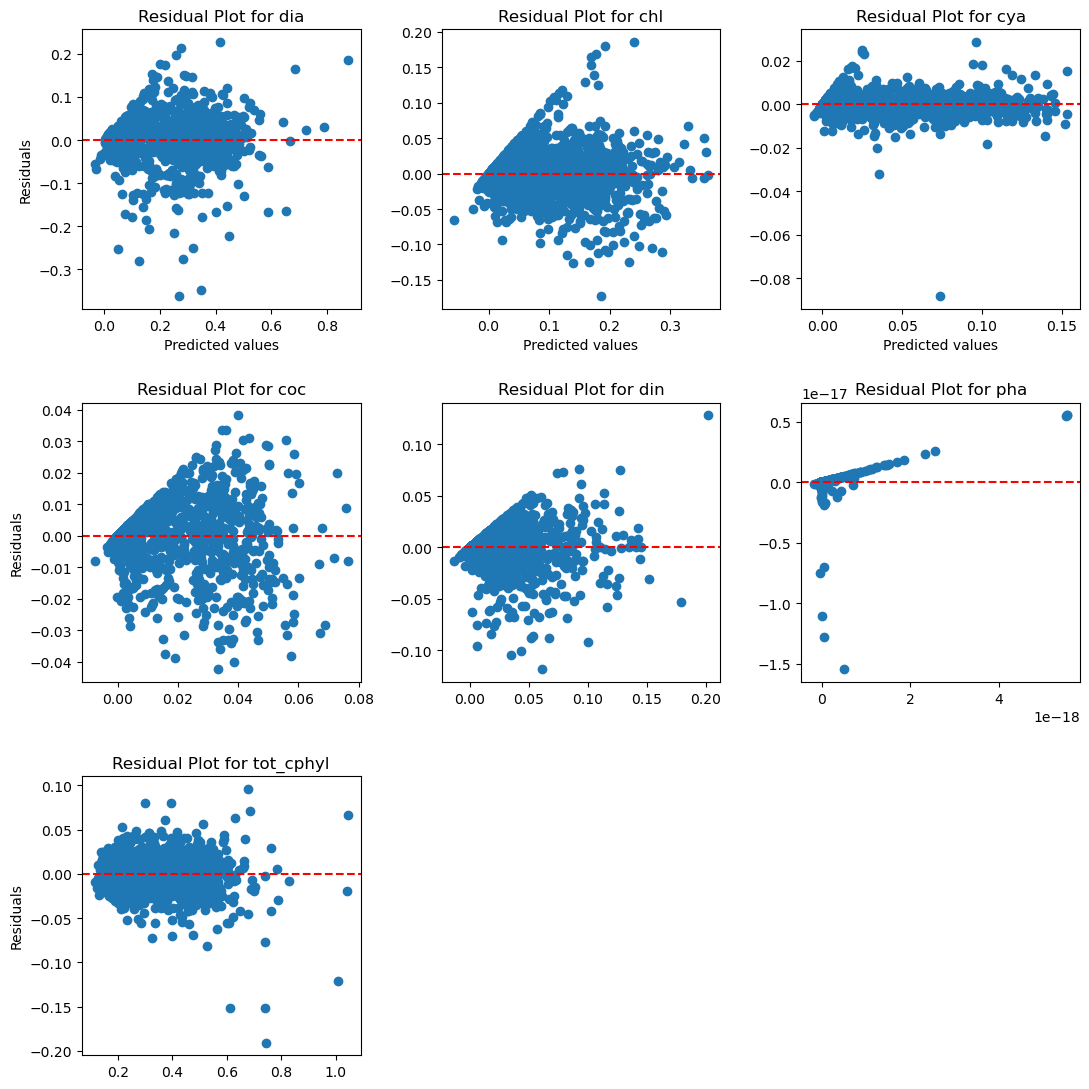

In [120]:
f, axs = pp.subplots(nrows=3, ncols=3, figsize=(11, 11))
for ax, col in zip(axs.ravel(), dY_test.columns):
    try:
        plot_residuals(dY_test[col].values, dY_pred_rs[col].values, ax, col)
    except:
        logger.error(f"problem with {col}")
    ss = ax.get_subplotspec()
    if not ss.is_first_col:
        ax.set_ylabel("")
    if not ss.is_first_row:
        ax.set_xlabel("")
for ax in axs.flat[-2:]:
    ax.set_visible(False)
f.tight_layout()   

In [73]:
dX_test.shape

(1953, 501)

In [105]:
def plot_regression(true, predicted, name, ax=None):
    if ax is None:
        f, ax = pp.subplots()
    ax.scatter(true, predicted, color='k')
    ax.plot((0, 1), (0, 1), ls='--', color='r')
    ss = ax.get_subplotspec()
    if ss.is_first_col():
        ax.set_ylabel('pred.')
    else:
        ax.set_ylabel("")
    if  ss.is_last_row():    
        ax.set_xlabel('true')
    else:
        ax.set_xlabel("")
    ax.set_title(name)
    ax.set_aspect('equal')
    

In [123]:
r2 = eval_scores[col]['r2']
mae2truestd = eval_scores[col]['mae_2_true_std_ratio']
string = r'$R^2:$ ' + f'{r2:.2f}\n' + r'$MAE/STD_{true}:$ ' + f'{mae2truestd:.2f}'
string

'$R^2:$ 0.98\n$MAE/STD_{true}:$ 0.10'

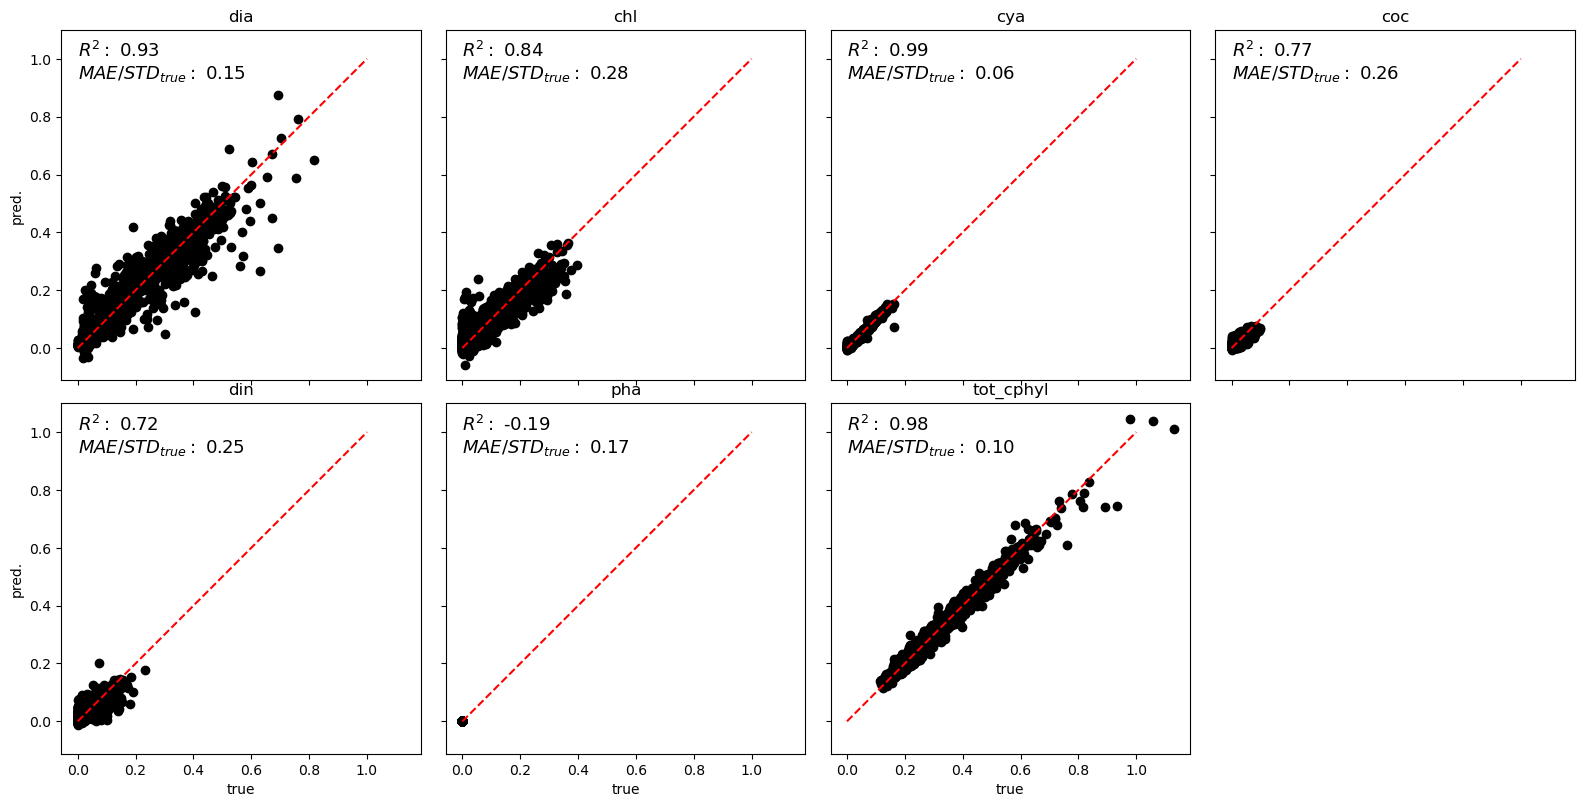

In [126]:
f, axs = pp.subplots(nrows=2, ncols=4, figsize=(16, 8), sharex=True, sharey=True)
for col, ax in zip(dY_test.columns, axs.ravel()):
    r2 = eval_scores[col]['r2']
    mae2truestd = eval_scores[col]['mae_2_true_std_ratio']
    plot_regression(dY_test[col], dY_pred_rs[col], col, ax=ax)
    string = r'$R^2:$ ' + f'{r2:.2f}\n' + r'$MAE/STD_{true}:$ ' + f'{mae2truestd:.2f}'
    ax.text(0, 0.93, string, fontdict=dict(fontsize=13))
for ax in axs.ravel()[-1:]:
    ax.set_visible(False)
f.tight_layout()